In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
spending_features = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Total_Spending'
]





2. **Data Preparation**: We will standardize the selected features to ensure that they are on the same scale.

In [57]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv('../featured_customer_segmentation.csv')

# Select relevant spending columns
X = df[spending_features]

# extract ratios for all the spending features
# Create ratio features for spending categories, excluding the Total_Spending itself
spending_categories = [feature for feature in spending_features if feature != 'Total_Spending']
for feature in spending_categories:
    X[f'{feature}_ratio'] = X[feature] / X['Total_Spending'].replace(0, 1)  # Avoid division by zero

print(X.head())

# Append total spending and actual spending amounts to df_ratios
df_ratios = X[[f'{feature}_ratio' for feature in spending_categories]].copy()
df_ratios['Total_Spending'] = X['Total_Spending']
for feature in spending_categories:
    df_ratios[feature] = X[feature]

print(df_ratios.head())

# Scale the features (only ratios for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ratios[[f'{feature}_ratio' for feature in spending_categories]])

print(df_ratios.head())



   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0       635         81              546            120.5                81   
1        11          1                6              2.0                 1   
2       426         49              127            111.0                21   
3        11          4               20             10.0                 3   
4       173         43              118             46.0                27   

   MntGoldProds  Total_Spending  MntWines_ratio  MntFruits_ratio  \
0          88.0          1551.5        0.409281         0.052208   
1           6.0            27.0        0.407407         0.037037   
2          42.0           776.0        0.548969         0.063144   
3           5.0            53.0        0.207547         0.075472   
4          15.0           422.0        0.409953         0.101896   

   MntMeatProducts_ratio  MntFishProducts_ratio  MntSweetProducts_ratio  \
0               0.351917               0.077667

/var/folders/t4/fp87jt9n1438scx07zt_2q_80000gp/T/ipykernel_52934/4091634094.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{feature}_ratio'] = X[feature] / X['Total_Spending'].replace(0, 1)  # Avoid division by zero
/var/folders/t4/fp87jt9n1438scx07zt_2q_80000gp/T/ipykernel_52934/4091634094.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{feature}_ratio'] = X[feature] / X['Total_Spending'].replace(0, 1)  # Avoid division by zero
/var/folders/t4/fp87jt9n1438scx07zt_2q_80000gp/T/ipykernel_5

3. Optimizing the **number of clusters** using the Elbow Method

[13440.000000000002, 9338.521568291335, 7260.948676197477, 6534.5953359888845, 6013.296957549021, 5308.496669362053, 4895.082396434314, 4625.696509868743, 4362.805188081022]


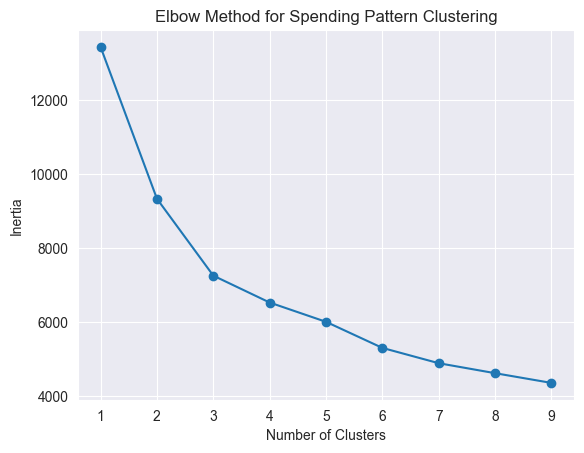

Optimal number of clusters (elbow method): 3


In [58]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Spending Pattern Clustering')
plt.grid(True)
plt.show()

# --- Automatically choose best n using the "elbow" (maximum curvature) ---
def optimal_number_of_clusters(inertia):
    # Calculate the distances from each point to the line between first and last inertia
    x = np.arange(1, len(inertia) + 1)
    y = np.array(inertia)
    # Line: (x0, y0) to (x1, y1)
    x0, y0 = x[0], y[0]
    x1, y1 = x[-1], y[-1]
    # Compute distances
    distances = np.abs((y1 - y0) * x - (x1 - x0) * y + x1*y0 - y1*x0) / np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
    return x[np.argmax(distances)]

best_n = optimal_number_of_clusters(inertia)
print(f"Optimal number of clusters (elbow method): {best_n}")


4. **Applying KMeans Clustering** with the optimal number of clusters
We will choose 3 clusters based on the elbow method.
this is because the inertia starts to level off after 3 clusters, indicating that adding more clusters does not significantly reduce inertia.

Silhouette Score: 0.281 (range: -1 to 1, higher is better)
Calinski-Harabasz Index: 951.84 (higher is better)
Davies-Bouldin Index: 1.297 (lower is better)


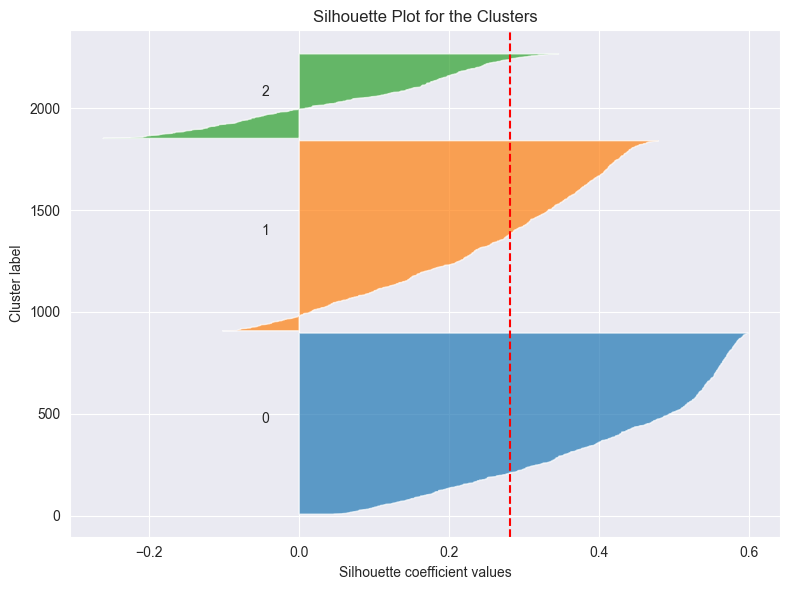

In [59]:
# Apply KMeans clustering with clusters
kmeans = KMeans(n_clusters=best_n, random_state=42)
df['Spending_Cluster'] = kmeans.fit_predict(X_scaled)

# --- Clustering Performance Scoring ---
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(X_scaled, df['Spending_Cluster'])
calinski_score = calinski_harabasz_score(X_scaled, df['Spending_Cluster'])
davies_score = davies_bouldin_score(X_scaled, df['Spending_Cluster'])

print(f"Silhouette Score: {sil_score:.3f} (range: -1 to 1, higher is better)")
print(f"Calinski-Harabasz Index: {calinski_score:.2f} (higher is better)")
print(f"Davies-Bouldin Index: {davies_score:.3f} (lower is better)")

# --- Plot clustering performance scores ---
import matplotlib.pyplot as plt

scores = {
    "Silhouette": sil_score,
    "Calinski-Harabasz": calinski_score,
    "Davies-Bouldin": davies_score
}

# --- Silhouette plot ---
from sklearn.metrics import silhouette_samples
import numpy as np

sample_silhouette_values = silhouette_samples(X_scaled, df['Spending_Cluster'])
y_lower = 10
n_clusters = best_n
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[df['Spending_Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between clusters

plt.axvline(x=sil_score, color="red", linestyle="--")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette Plot for the Clusters")
plt.tight_layout()
plt.show()


5. **Analyzing Cluster Characteristics**

We will analyze the characteristics of each cluster by computing the mean spending for each product category.

We will also visualize the average spending per product category for each cluster using a grouped bar chart.


                    MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Spending_Cluster                                                            
0                 434.395506  14.408989       104.965169        20.485955   
1                 296.843683  31.455032       248.481799        48.113490   
2                  30.935096  15.283654        29.939904        21.079327   

                  MntSweetProducts  MntGoldProds  Total_Spending  
Spending_Cluster                                                  
0                        14.514607     39.685393      628.455618  
1                        32.178801     44.153640      701.226445  
2                        14.826923     28.588942      140.653846  


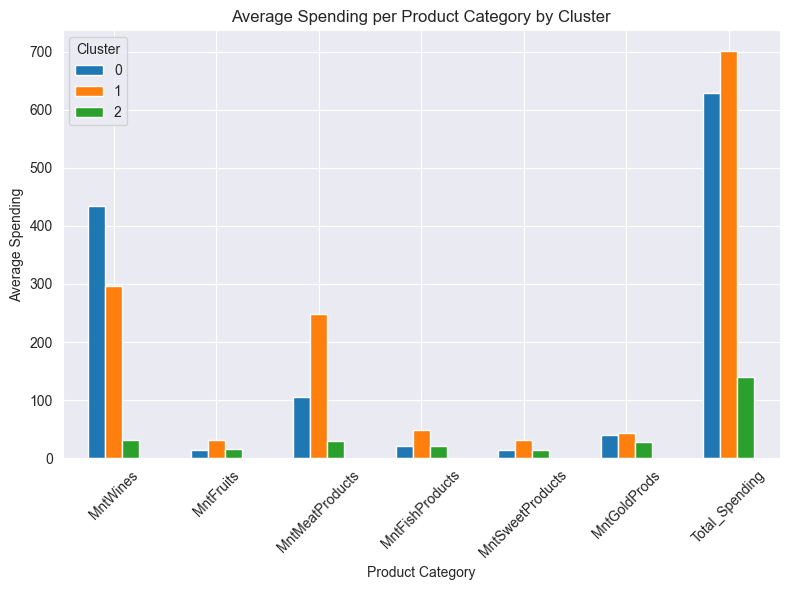

In [60]:
# Group by cluster and compute means
cluster_means = df.groupby('Spending_Cluster')[spending_features].mean()

print(cluster_means)

# Transpose for easier plotting (products on x-axis)
cluster_means_T = cluster_means.T

# Plot grouped bar chart
cluster_means_T.plot(kind='bar', figsize=(8, 6))

plt.title('Average Spending per Product Category by Cluster')
plt.xlabel('Product Category')
plt.ylabel('Average Spending')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This is a stacked bar chart showing the average spending per product category for each cluster. Each segment of the bar represents the average spending for a specific product category, and different colors represent different clusters. This visualization helps us understand how each cluster allocates its spending across various product categories.

                  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Spending_Cluster                                                          
0                    69.12       2.29            16.70             3.26   
1                    42.33       4.49            35.44             6.86   
2                    21.99      10.87            21.29            14.99   

                  MntSweetProducts  MntGoldProds  
Spending_Cluster                                  
0                             2.31          6.31  
1                             4.59          6.30  
2                            10.54         20.33  


/var/folders/t4/fp87jt9n1438scx07zt_2q_80000gp/T/ipykernel_52934/3004425831.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])


<Figure size 1200x800 with 0 Axes>

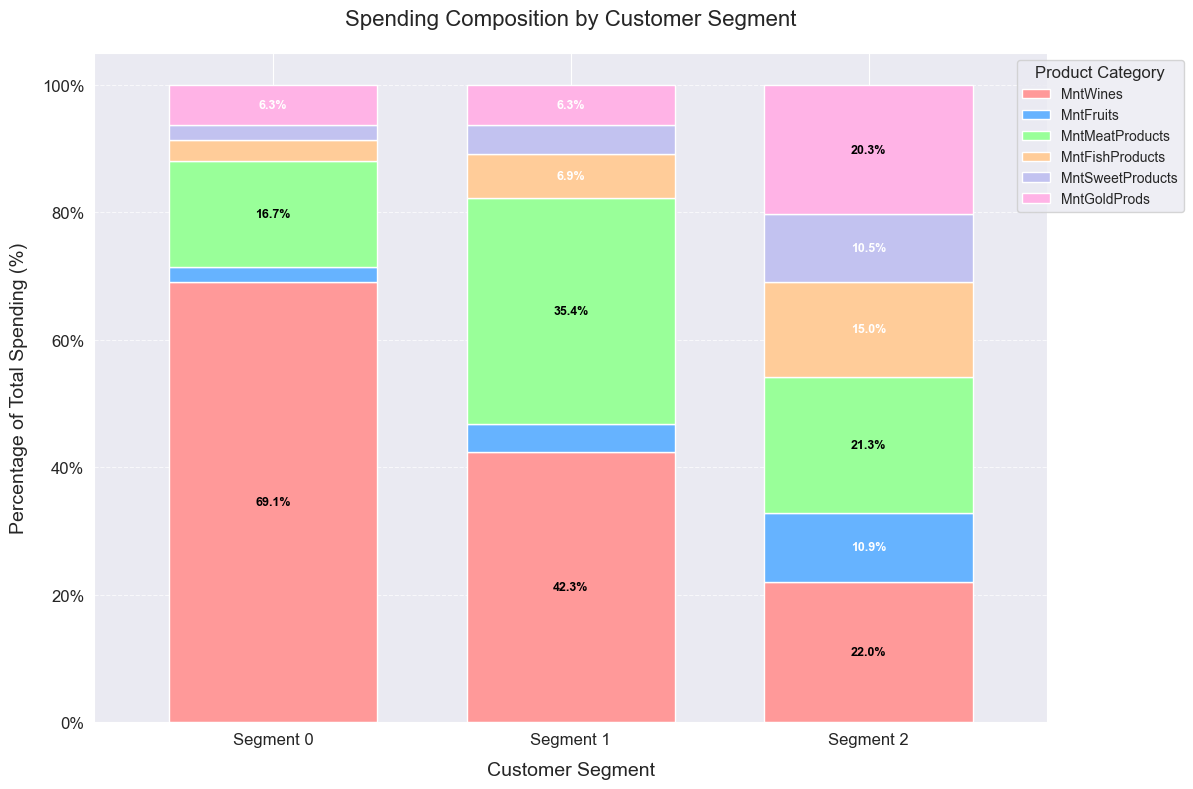

In [61]:
# Normalize category spending by total spending per cluster
normalized = df.groupby('Spending_Cluster')[
    ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
     'MntSweetProducts', 'MntGoldProds']
].mean()

# Add total spending per cluster
normalized['Total'] = normalized.sum(axis=1)

# Divide each category by total to get proportions
normalized_pct = normalized.div(normalized['Total'], axis=0).drop(columns='Total')

# Optional: Multiply by 100 for percentage
normalized_pct *= 100

print(normalized_pct.round(2))

# plot the normalized dta
# Create a colorful stacked bar chart with improved styling
plt.figure(figsize=(12, 8))

# Use a colorful palette
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']
normalized_pct.plot(
    kind='bar',
    stacked=True,  # Use stacked bars to show composition
    figsize=(12, 8),
    color=colors,
    width=0.7,  # Slightly thinner bars
    edgecolor='white'  # White edge for contrast between segments
)

# Enhance styling
plt.title('Spending Composition by Customer Segment', fontsize=16, pad=20)
plt.xlabel('Customer Segment', fontsize=14, labelpad=10)
plt.ylabel('Percentage of Total Spending (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage signs to y-axis
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])

# Improve legend
plt.legend(
    title='Product Category',
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    bbox_to_anchor=(1.15, 1)
)

# Add value labels on the stacked bars
for i, cluster in enumerate(normalized_pct.index):
    cumulative = 0
    for j, col in enumerate(normalized_pct.columns):
        value = normalized_pct.loc[cluster, col]
        if value > 5:  # Only show labels for segments > 5%
            plt.text(
                i,
                cumulative + value / 2,  # Center of segment
                f"{value:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='black' if value > 15 else 'white'  # Better contrast
            )
        cumulative += value

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rename x-axis labels to more meaningful names
plt.gca().set_xticklabels([
    'Segment 0',
    'Segment 1',
    'Segment 2'
])

plt.tight_layout()
plt.show()


Average Income per Cluster:
Spending_Cluster
0    55498.94
1    57524.41
2    31388.71
Name: Income, dtype: float64


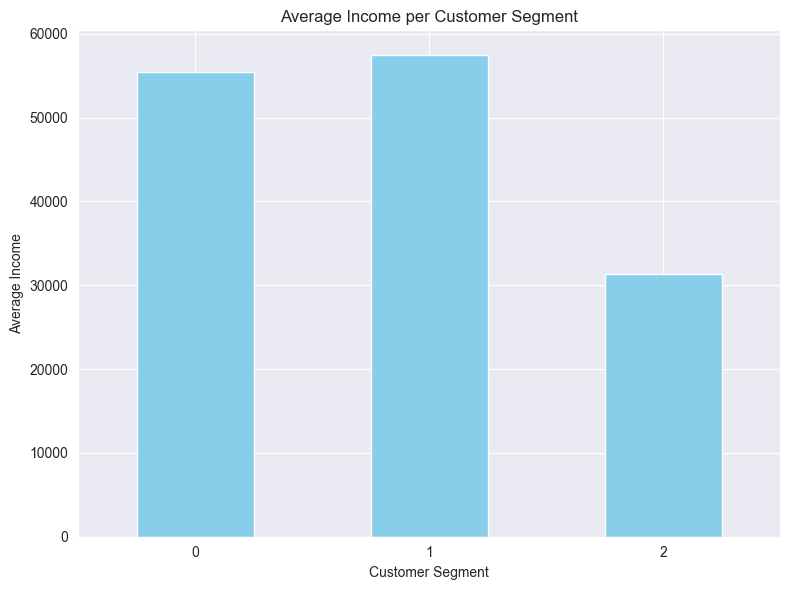

In [62]:
# average income per cluster
income_per_cluster = df.groupby('Spending_Cluster')['Income'].mean().round(2)
print("Average Income per Cluster:")
print(income_per_cluster)

# Plot average income per cluster
plt.figure(figsize=(8, 6))
income_per_cluster.plot(kind='bar', color='skyblue')
plt.title('Average Income per Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Income')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [63]:
#order of product preference per category
# Dictionary to store cluster-wise hierarchy
cluster_hierarchy = {}
cluster_means.drop('Total_Spending', axis=1, inplace=True)  # Drop Total_Spending for hierarchy
# Loop through each cluster and sort categories
for cluster_id in cluster_means.index:
    sorted_categories = cluster_means.loc[cluster_id].sort_values(ascending=False).index.tolist()
    cluster_hierarchy[cluster_id] = sorted_categories

# Display the result
for cluster, preferences in cluster_hierarchy.items():
    print(f"Cluster {cluster} preference hierarchy: {preferences}")


Cluster 0 preference hierarchy: ['MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntFishProducts', 'MntSweetProducts', 'MntFruits']
Cluster 1 preference hierarchy: ['MntWines', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds', 'MntSweetProducts', 'MntFruits']
Cluster 2 preference hierarchy: ['MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntFishProducts', 'MntFruits', 'MntSweetProducts']


 SCATTER PLOT ANALYSIS FOR SPENDING CLUSTERS

1. PCA-based Scatter Plot for Spending Cluster Visualization


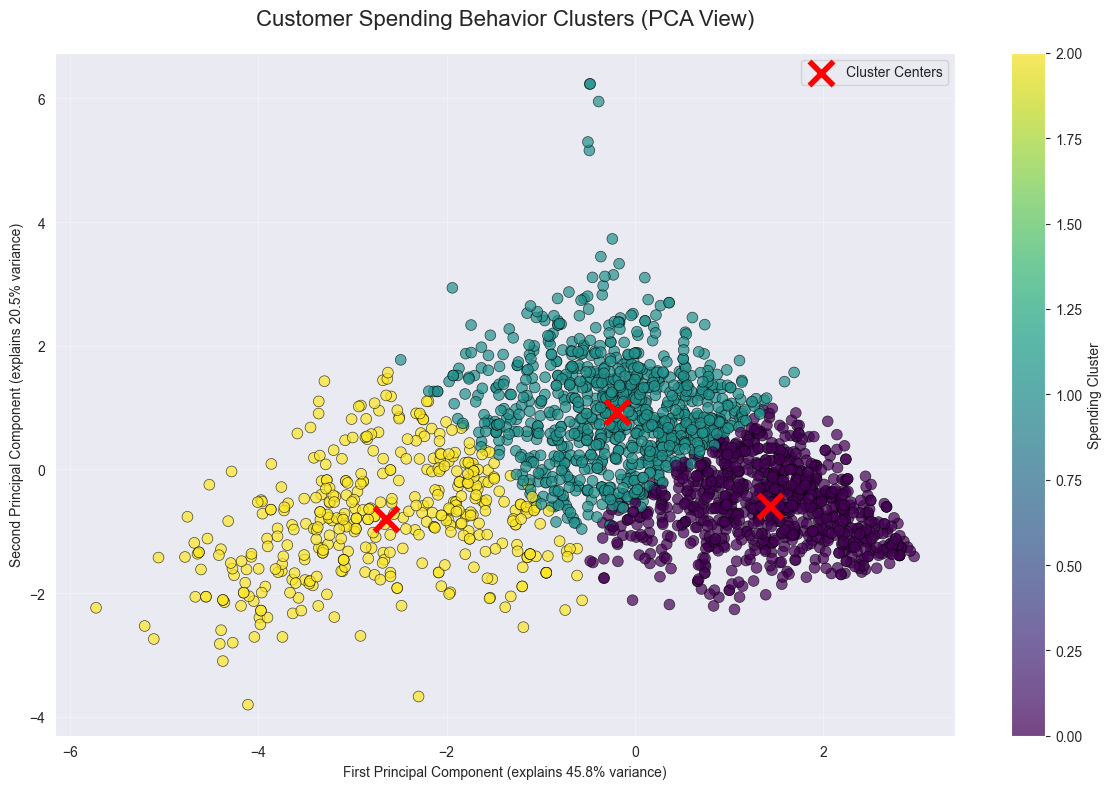

PCA explains 66.3% of total variance in spending patterns


In [64]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA



print(" SCATTER PLOT ANALYSIS FOR SPENDING CLUSTERS")
print("="*60)

# 1. PCA Scatter Plot - Most comprehensive view of all spending patterns
print("\n1. PCA-based Scatter Plot for Spending Cluster Visualization")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Spending_Cluster'], 
                     cmap='viridis', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Spending Cluster')
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Spending Behavior Clusters (PCA View)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', 
           s=300, linewidths=4, label='Cluster Centers')
plt.legend()
plt.tight_layout()
plt.show()

print(f"PCA explains {sum(pca.explained_variance_ratio_):.1%} of total variance in spending patterns")

In [66]:
# append column to ../featured_customer_segmentation_with_clusters.csv

import os

output_path = '../featured_customer_segmentation_with_clusters.csv'
if os.path.exists(output_path):
    # Load existing file and update/append the Spending_Cluster column
    existing_df = pd.read_csv(output_path)
    if 'Spending_Cluster' in existing_df.columns:
        existing_df['Spending_Cluster'] = df['Spending_Cluster']
    else:
        existing_df['Spending_Cluster'] = df['Spending_Cluster']
    existing_df.to_csv(output_path, index=False)
    print(f"Updated 'Spending_Cluster' column in {output_path}")
else:
    # Save new file with Spending_Cluster column
    df.to_csv(output_path, index=False)
    print(f"Created {output_path} with 'Spending_Cluster' column")


Updated 'Spending_Cluster' column in ../featured_customer_segmentation_with_clusters.csv
